In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [22]:
features = pd.read_csv('data/features.csv', index_col='match_id')

In [23]:
match_results = features.iloc[:,-6:]
Xdirty = features.drop(columns=match_results.columns)
X = Xdirty.fillna(0)

In [24]:
Xdirty.columns[Xdirty.isna().any()].tolist()

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

In [25]:
Nan_count = len(Xdirty)-Xdirty.count()
Nan_count[Nan_count>0].sort_values(ascending=False)/len(Xdirty)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

In [45]:
X = Xdirty.fillna(0)
X.shape

(97230, 102)

In [27]:
y = match_results['radiant_win']

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
X_scaled = scaler.transform(X)

In [31]:
categorial=['lobby_type']
team=('r','d')
for l in team:
    for i in range(1,6):
        categorial.append('{}{}_hero'.format(l,i))

In [32]:
X_no_cat = X.drop(columns=categorial)
scaler.fit(X_no_cat)
X_scaled2 = scaler.transform(X_no_cat)

In [33]:
X_hero = X[categorial].iloc[:,1:]
unique_hero = len(np.unique(X_hero))
ids = X_hero.iloc[:,1].max()

In [35]:
X_pick = np.zeros((X_hero.shape[0], ids))

for i, match_id in enumerate(X_hero.index):
    for p in range(5):
        X_pick[i, X_hero.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_hero.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [36]:
X_pick = pd.DataFrame(X_pick, index=X_hero.index, columns=['{}_hero'.format(i) for i in range (ids)])

In [37]:
X_ = pd.concat([X_no_cat, X_pick],axis=1)

In [38]:
scaler.fit(X_)
X_scaled3 = scaler.transform(X_)

In [39]:
X_test_dirty = pd.read_csv('features_test.csv', index_col='match_id')
X_test_dirty.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [47]:
X_hero = X_test_dirty[categorial].iloc[:,1:]

In [48]:
X_test = X_test_dirty.drop(columns=categorial).fillna(0)
X_test.shape, X_hero.shape

((17177, 91), (17177, 10))

In [49]:
X_pick = np.zeros((X_hero.shape[0], ids))

for i, match_id in enumerate(X_hero.index):
    for p in range(5):
        X_pick[i, X_hero.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_hero.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick =pd.DataFrame(X_pick, index=X_hero.index, columns=['{}_hero'.format(i) for i in range(ids)])
X_pick.shape

(17177, 112)

In [50]:
X_test = pd.concat([X_test,X_pick],axis=1)

In [51]:
scaler.fit(X_test)
X_scale = scaler.transform(X_test)

In [53]:
score_summary=np.zeros(5)

model = LogisticRegression(penalty='l2', C=0.01)
model.fit(X_scaled3,y)
y_pred = pd.Series(model.predict_proba(X_scale)[:,1])
print(y_pred)

C:\Users\Alexey.000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0        0.822689
1        0.756018
2        0.188658
3        0.856746
4        0.241456
           ...   
17172    0.718821
17173    0.631443
17174    0.233771
17175    0.631057
17176    0.429138
Length: 17177, dtype: float64


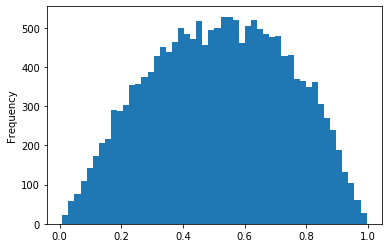

In [54]:
y_pred.plot.hist(bins=50)

In [73]:
submit = pd.DataFrame(y_pred,index=X_test.index,columns=['radiant_win']).fillna(0)

In [101]:
submit.to_csv('submit.csv', index=True)